# Dynamic Visualizations with Matplotlib

## Example: Updating Lines in a Plot

<IPython.core.display.Javascript object>


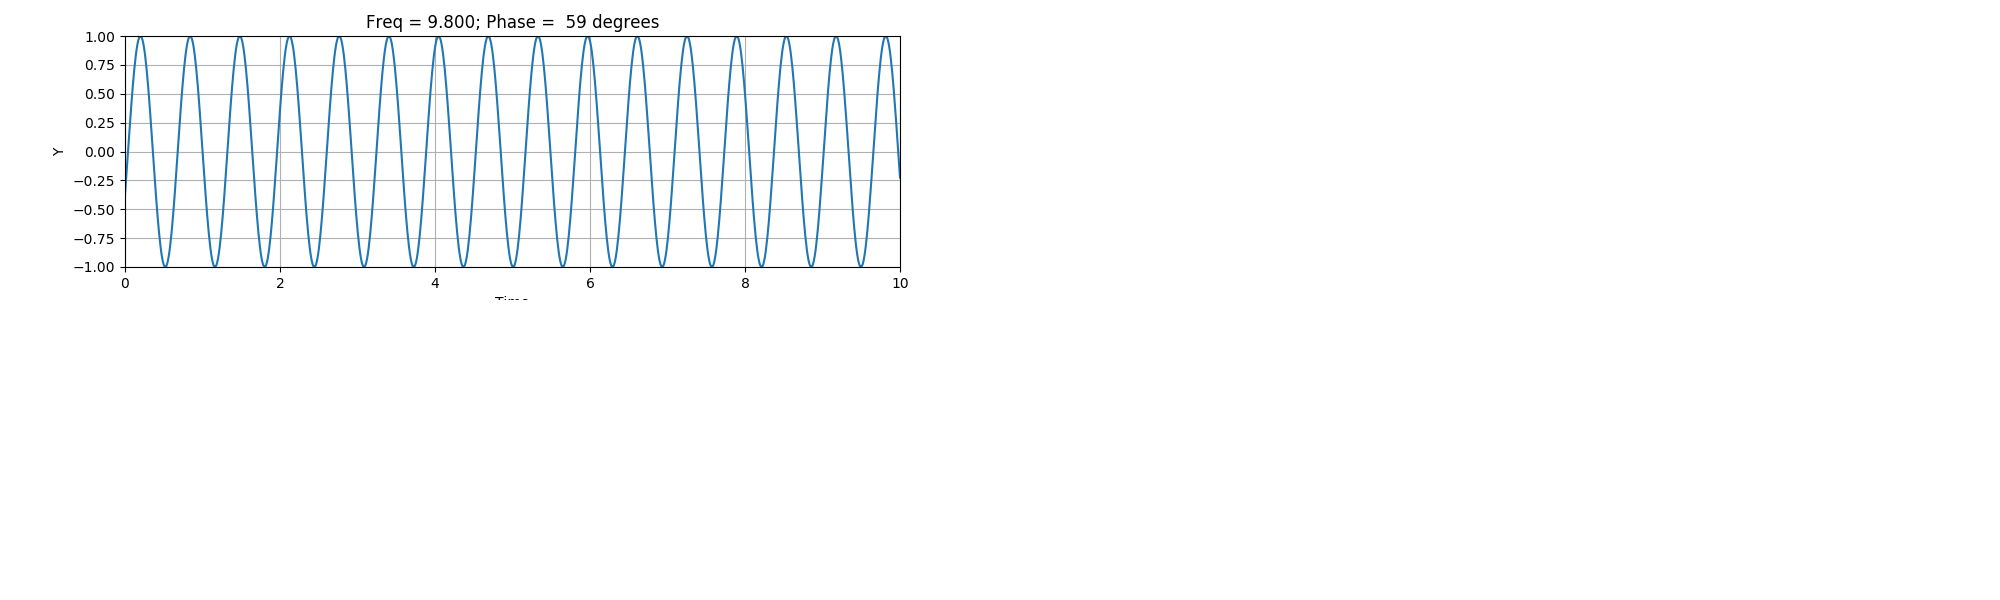

In [1]:
%matplotlib notebook

from pylab import *
import time
from ipywidgets import interact

def pltfreq(freq):
    fig,ax = subplots(1,1,figsize=(10,3))
    ax.set_xlabel('Time')
    ax.set_ylabel('Y')
    ax.set_xlim(0,10.0)
    ax.set_ylim(-1,1)
    grid()
    for phase in range(60):
        t = linspace(0,10.0,1000)
        y = sin(freq*t + phase/10.0)
        if len(ax.lines):
            #ax.lines[0].set_xdata(t)
            ax.lines[0].set_ydata(y)
            ax.set_title("Freq = {0:5.3f}; Phase = {1:3d} degrees".format(freq,phase))
        else:
            ax.plot(t,y)
        time.sleep(0.01)
        fig.canvas.draw()
    close()

# create room for the interactive plot
fig,ax = subplots(1,1,figsize=(10,3))

# start interactive
r = interact(pltfreq, freq=(1.0,10.0))

## Example: Phase Plane Dynamics of an Exothermic CSTR

This example is intended as an introduction to the nonlinear dynamics of an exothermic continuous stirred-tank reactor. The example has been studied by countless researchers and students since the pioneering work of Amundson and Aris in the 1950's. The particular formulation and parameter values described below are taken from example 2.5 from Seborg, Edgar, Mellichamp and Doyle (SEMD).


### Model Equations

\begin{align*}
V\frac{dc_A}{dt} & = q(c_{Ai} - c_A)-Vkc_A \\
V\rho C_p\frac{dT}{dt} & = \rho q C_p(T_i - T) + (-\Delta H_R)Vkc_A + UA(T_c - T)
\end{align*}

Normalizing the equations to isolate the time rates of change of $c_A$ and $T$ give

\begin{align*}
\frac{dc_A}{dt} & = \frac{q}{V}(c_{Ai} - c_A)- kc_A \\
\frac{dT}{dt} & = \frac{q}{V}(T_i - T) + \frac{-\Delta H_R}{\rho C_p}kc_A + \frac{UA}{V\rho C_p}(T_c - T)
\end{align*}

which are the equations that will be integrated below.


<IPython.core.display.Javascript object>


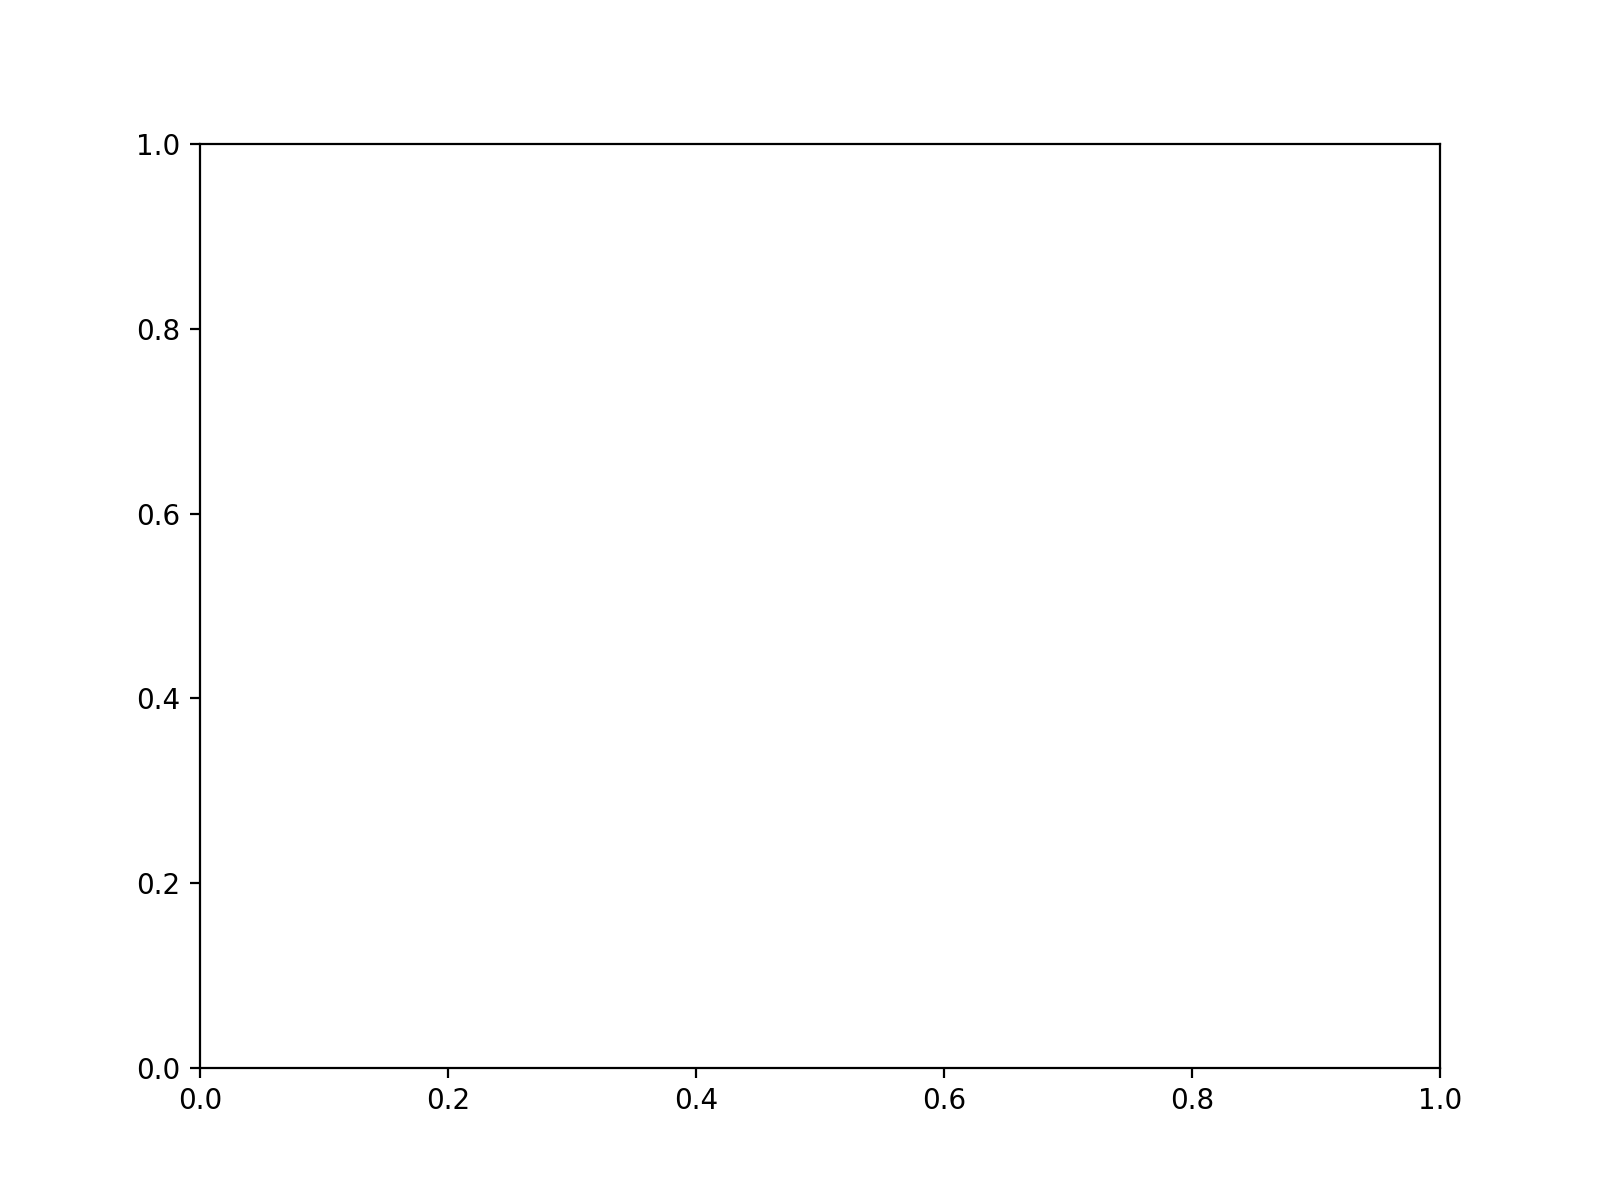

In [1]:
%matplotlib notebook

from pylab import *
import time
from ipywidgets import interact, interactive
from scipy.integrate import odeint

q = 100.0       # Flowrate [L/min]
cAi = 1.0       # Inlet feed concentration [mol/L]
Ti  = 350.0     # Inlet feed temperature [K]
V   = 100.0     # Volume [L]
rho = 1000.0    # Density [g/L]
Cp   = 0.239    # Heat capacity [J/g/K]
dHr = -5.0e4    # Heat of reaction [J/mol]

ER  = 8750.0    # Ea/R [K]
k0  = 7.2e10    # Arrhenius rate constant
UA  = 5.0e4     # Heat transfer [J/min/K]
Tc  = 300.0     # Coolant temperature [K]

cA0 = 0.18;     # Initial concentration [mol/L]
T0  = 380.0;    # Initial temperature [K]

dt = 0.05;      # sampling time

def k(T):
    return k0*exp(-ER/T)

def deriv(y,t):
    cA,T = y
    dcA = (q/V)*(cAi - cA) - k(T)*cA
    dT = (q/V)*(Ti - T) + (-dHr/rho/Cp)*k(T)*cA + (UA/V/rho/Cp)*(Tc-T)
    return [dcA,dT]

def cstr(IC,t):
    return odeint(deriv,IC,t)

def cstr_sim(C_initial, T_initial, T_cooling, t_final):
    global Tc
    Tc = T_cooling
    IC = [C_initial, T_initial]
    t = linspace(0,t_final,t_final/dt)
    
    # set up figure and phase plot
    fig,ax = subplots(1,1,figsize=(8,6))
    ax.set_xlabel('Concentration [gmol/liter]')
    ax.set_ylabel('Temperature [K]')
    ax.set_title('Nonlinear CSTR with Tc = {0:6.2f} K'.format(Tc))
    ax.set_xlim(0,1.0)
    ax.set_ylim(300,460)
    grid()
    
    # plot nullclines
    T = linspace(300.0,460.0,1000)
    plot((q/V)*cAi/((q/V) + k(T)),T,'b--')
    plot(((q/V)*(Ti-T) + (UA/V/rho/Cp)*(Tc-T))/((dHr/rho/Cp)*k(T)),T,'r--')
    
    # plot initial condition, trajectory, and current state
    plot(IC[0],IC[1],'r.',ms=20)
    plot(IC[0],IC[1],'g',lw=2)
    plot(IC[0],IC[1],'g.',ms=20)
    
    # add slots for current state readout
    text(0.7,410.0,'t = {0:5.2f} min'.format(0.0))   
    text(0.7,400.0,'C = {0:5.3f} gmol/l'.format(C_initial))
    text(0.7,390.0,'T = {0:5.1f} K'.format(T_initial))
    legend(['dcA = 0','dT = 0','Initial Condition'])
    fig.canvas.draw()

    # update phase plot
    y = odeint(deriv,IC,t)
    Cdata = []
    Tdata = []
    for idx in range(len(t)):
        # update state
        Cdata.append(y[idx,0])
        Tdata.append(y[idx,1])
        # update state trajectory
        ax.lines[3].set_xdata(Cdata)
        ax.lines[3].set_ydata(Tdata)
        # update current state marker
        ax.lines[4].set_xdata(y[idx,0])
        ax.lines[4].set_ydata(y[idx,1])
        # update readout
        ax.texts[0].set_text('t = {0:5.2f} min'.format(t[idx]))
        ax.texts[1].set_text('C = {0:5.3f} gmol/l'.format(y[idx,0]))
        ax.texts[2].set_text('T = {0:5.1f} K'.format(y[idx,1]))
        # draw and wait
        fig.canvas.draw()
        time.sleep(0.001)

# add sliders and run button
interact(cstr_sim, __manual=True, \
         C_initial = (0.0,1.0), \
         T_initial = (300.0,440.0), \
         T_cooling = (290.0,320.0), \
         t_final = (0.0,20.0))

# create room for the interactive plot
fig,ax = subplots(1,1,figsize=(8,6))


In [ ]:
xdata = 
xdata.append(2)
xdata.append(3)
xdata

In [13]:
%matplotlib notebook
from ipywidgets import interactive
from IPython.display import display
import time

def r_update(x):
    return x

def s_update(y):
    return y

s = interactive(r_update, x = (0.0,20.0),continuous_update=True)
r = interactive(s_update, y = (100.0,200.0))
display(s,r)

for k in range(10):
    print(r.kwargs,s.kwargs)
    time.sleep(2)


190.5

In [ ]:
from IPython.display import display
display(s)

In [ ]:
import ipywidgets as widgets
int_range = widgets.IntSlider()
display(int_range)

def on_value_change(change):
    print(change['new'])

int_range.observe(on_value_change, names='value')

In [ ]:
def slow_function(i):
    print(int(i),list(x for x in range(int(i)) if 
                str(x)==str(x)[::-1] and 
                str(x**2)==str(x**2)[::-1]))
    return

In [ ]:
slow_function(10000000)

In [ ]:
from ipywidgets import FloatSlider
interact(slow_function,i=FloatSlider(min=1e5, max=1e7, step=1e5,continuous_update=False))